<a href="https://colab.research.google.com/github/enakai00/colab_rlbook/blob/master/Chapter03/05_Car_Rental_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats import poisson
matplotlib.rcParams['font.size'] = 12

In [0]:
class CarRental:
  def __init__(self, size=20,
               fst_rent_mean=3, snd_rent_mean=4,
               fst_ret_mean=3, snd_ret_mean=2):
    self.size = size
    self.fst_rent_mean = fst_rent_mean
    self.snd_rent_mean = snd_rent_mean    
    self.fst_ret_mean = fst_ret_mean
    self.snd_ret_mean = snd_ret_mean       

    self.states = [(fst, snd) for fst in range(size+1) for snd in range(size+1)]
    self.value = {}
    self.policy = {} # Greedy policy
    
    # Initialize with 0 values
    for s in self.states:
      self.value[s] = 0
      
    # Initialize with policy of moving no cars
    for s in self.states:
      self.policy[s] = 0

    self.r_ave = {}
    self.p_sum_r = {}

In [0]:
def show_result(car_rental):
  fig = plt.figure(figsize=(10, 16))

  value = np.zeros((car_rental.size+1, car_rental.size+1), dtype=int)
  policy = np.zeros((car_rental.size+1, car_rental.size+1))
  for s in car_rental.states:
    (fst, snd) = s
    value[fst][snd] = int(car_rental.value[s]) # (x, y) = (snd, fst) 
    policy[fst][snd] = car_rental.policy[s] # (x, y) = (snd, fst)

  subplot = fig.add_subplot(2, 1, 1) 
  subplot.set_title('Value')
  sns.heatmap(value, cbar=False, annot=True, fmt='d', cmap='coolwarm', ax=subplot)
  subplot = fig.add_subplot(2, 1, 2)
  subplot.set_title('Policy')
  sns.heatmap(policy, cbar=False, annot=True, cmap='coolwarm', ax=subplot)

In [0]:
def memoize(f):
  cache = {}
  def helper(*args):
    if args not in cache:
      cache[args] = f(*args)
    return cache[args]
  return helper

@memoize
def _poisson_pmf(n, mean):
  return poisson.pmf(n, mean)
  
@memoize
def poisson_pmf(n, n_max, mean):
  if n > n_max:
    return 0
  if n == n_max:
    return 1-sum([poisson.pmf(n, mean) for n in range(n_max)])
  return _poisson_pmf(n, mean)

In [0]:
def precalc(car_rental):
  size = car_rental.size
  fst_rent_mean = car_rental.fst_rent_mean
  snd_rent_mean = car_rental.snd_rent_mean    
  fst_ret_mean = car_rental.fst_ret_mean
  snd_ret_mean = car_rental.snd_ret_mean  

  c = 0
  for s in car_rental.states:
    if c % size == 0:
      print('.', end='')
    c += 1

    (_fst, _snd) = s

    for a in range(-min(_snd, 5), min(_fst, 5)+1):
      car_rental.r_ave[(s, a)] = 0
      (fst, snd) = s
      fst -= a # Moving cars
      snd += a # Moving cars

      for fst_rent in range(fst+1):
      # Prob for fst_rent
        prob1 = poisson_pmf(fst_rent, fst, fst_rent_mean)
        
        for snd_rent in range(snd+1):
        # Prob for fst_rent * snd_rent
          prob2 = prob1 * poisson_pmf(snd_rent, snd, snd_rent_mean)
          r = -2 * abs(a) + 10 * (fst_rent + snd_rent)

          for fst_ret in range(size-(fst-fst_rent)+1):
          # Prob for fst_rent * snd_rent * fst_ret
            prob3 = prob2 * poisson_pmf(fst_ret, size-(fst-fst_rent), fst_ret_mean)

            for snd_ret in range(size-(snd-snd_rent)+1):
            # Prob for fst_rent * snd_rent * fst_ret * snd_ret
              prob = prob3 * poisson_pmf(snd_ret, size-(snd-snd_rent), snd_ret_mean)
              s_new = (fst - fst_rent + fst_ret, snd - snd_rent + snd_ret)

              car_rental.r_ave[(s, a)] += prob * r
              if (s, a, s_new) not in car_rental.p_sum_r.keys():
                car_rental.p_sum_r[(s, a, s_new)] = 0
              car_rental.p_sum_r[(s, a, s_new)] += prob

  print('\n')

In [0]:
def get_v_new(car_rental, s, a, gamma=0.9):
  v_new = car_rental.r_ave[(s, a)]
  for s_new in car_rental.states:
    if (s, a, s_new) not in car_rental.p_sum_r.keys():
      car_rental.p_sum_r[(s, a, s_new)] = 0
    v_new += car_rental.p_sum_r[(s, a, s_new)] * gamma * car_rental.value[s_new]
  return v_new

In [0]:
def policy_update(car_rental, s):
  q_max = -10**10
  a_best = None
  (_fst, _snd) = s
  for a in range(-min(_snd, 5), min(_fst, 5)+1):
    q = get_v_new(car_rental, s, a)
    if q > q_max:
      q_max = q
      a_best = a

  car_rental.policy[s] = a_best

  return q_max

In [0]:
def value_iteration(car_rental, delta=0.1):
  while True:
    delta_max = 0
    print('.', end='')
    for s in car_rental.states:
      v_new = policy_update(car_rental, s)
      delta_max = max(delta_max, abs(car_rental.value[s]-v_new))
      car_rental.value[s] = v_new

    if delta_max < delta:
      print('\n')
      break

In [0]:
car_rental = CarRental(size=20)

In [22]:
%%time
precalc(car_rental)

.......................

CPU times: user 3min 38s, sys: 366 ms, total: 3min 39s
Wall time: 3min 39s


In [23]:
%%time
value_iteration(car_rental)

....................................

CPU times: user 1min 18s, sys: 50 ms, total: 1min 18s
Wall time: 1min 18s


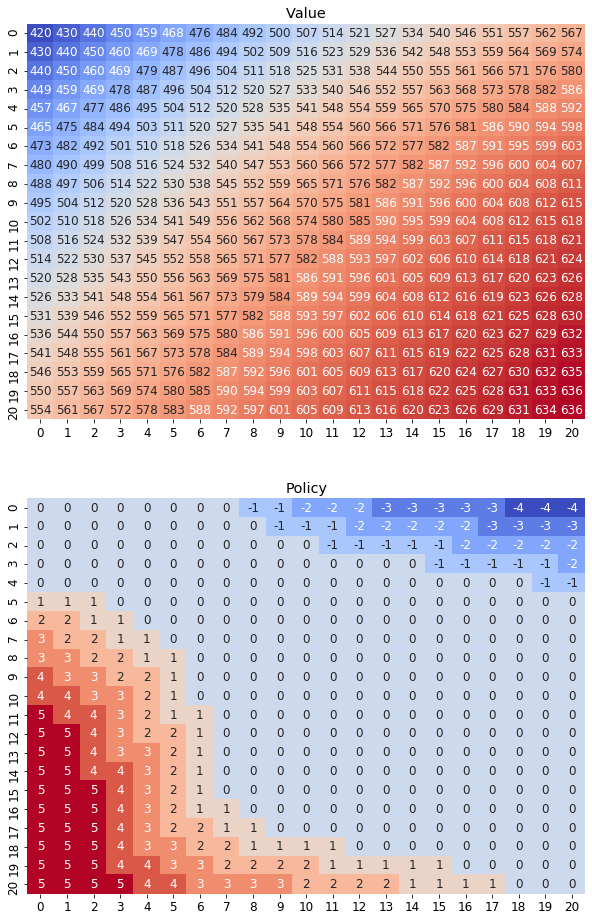

In [24]:
show_result(car_rental)